In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 14.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
import json
import numpy as np
import random
import re
import os
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import pipeline
import requests
from datasets import load_dataset
glove_file = 'glove.6B.50d.txt'
embedding_dim = 50

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))


# Load the dataset from Hugging Face
from datasets import load_dataset

# Load a subset of the dataset
dataset = load_dataset("naklecha/minecraft-question-answer-700k", split='train[:50000]')
# Print the first 20 entries
for i in range(20):
    example = dataset[i]
    print(f"Question {i+1}: {example['question']}")
    print(f"Answer {i+1}: {example['answer']}")
    print("\n")  # Adding a newline for better readability between entries


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/694814 [00:00<?, ? examples/s]

Question 1: What is the first statistic to decrease when a player performs energy-intensive actions in Minecraft?
Answer 1: Saturation is the first statistic to decrease when a player performs energy-intensive actions, and it must be completely depleted before the visible hunger meter begins decreasing.


Question 2: How does the game handle the consumption of cake when compared to eating other types of food?
Answer 2: Eating cake is distinct from other foods, as it must be placed and then right-clicked on to consume, whereas other foods can be eaten directly by the player. Additionally, cake has 7 edible slices, which become thinner as each slice is removed, whereas other foods typically restore a set amount of hunger and saturation points without any slice-based consumption mechanism.


Question 3: What is the average hunger restoration value of wheat in Minecraft?
Answer 3: The average hunger restoration value of wheat in Minecraft is 5. This means that consuming wheat will restore 

In [ ]:
# Load GloVe embeddings
def load_glove_embeddings(path):
    embeddings_index = {}
    with open(path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

def create_embedding_matrix(tokenizer, embeddings_index, vocab_size, embedding_dim):
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if i < vocab_size and embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

def preprocess_text(sentence):
    # Convert to lowercase
    sentence = sentence.lower()
    # Remove punctuation
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tokens = sentence.split()
    sentence = ' '.join([word for word in tokens if word not in stop_words])
    return sentence



In [ ]:
user_model_directory = "./user_models/"

mentioned_fact_indices = []
preprocessed_corpus_mapping = []

chatbot_likes = ["talking about minecraft", "sharing facts about minecraft", "the creepers in minecraft"]
max_len = 50
latent_dim = 256
vocab_size = 10000
embedding_size = 50
def preprocess_dataset(dataset):
    modified_corpus = []
    # Loop over each entry in the dataset
    for example in dataset:
        # Preprocess the question and answer texts
        question = preprocess_text(example['question'])
        answer = preprocess_text(example['answer'])

        # Combine question and answer with start and end tokens for each
        modified_corpus.append('startseq ' + question + ' endseq')
        modified_corpus.append('startseq ' + answer + ' endseq')
    return modified_corpus


# Preprocess the dataset
modified_corpus = preprocess_dataset(dataset)


# Train tokenizer on the modified corpus
vocab_size = 10000
max_len = 50
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(modified_corpus)
embeddings_index = load_glove_embeddings(glove_file)
embedding_matrix = create_embedding_matrix(tokenizer, embeddings_index, vocab_size, embedding_dim)

# Prepare sequences using the tokenizer
input_sequences = tokenizer.texts_to_sequences(modified_corpus)
input_sequences = pad_sequences(input_sequences, maxlen=max_len, padding='post')

# Decoder input and target data setup
decoder_input_data = np.zeros_like(input_sequences)
decoder_target_data = np.zeros_like(input_sequences)
decoder_input_data[:, 1:] = input_sequences[:, :-1]
decoder_target_data[:, :-1] = input_sequences[:, 1:]

encoder_inputs = Input(shape=(None,))
encoder_embedding = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(None,))
decoder_embedding_layer = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False)
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit([input_sequences, decoder_input_data], np.expand_dims(decoder_target_data, -1),
                    batch_size=16, epochs=5)

encoder_model = Model(encoder_inputs, encoder_states)

decoder_inputs_inf = Input(shape=(None,))
decoder_embedding_layer_inf = decoder_embedding_layer
decoder_embedding_inf = decoder_embedding_layer_inf(decoder_inputs_inf)
decoder_states_inputs = [Input(shape=(latent_dim,)), Input(shape=(latent_dim,))]
decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states_inf = [state_h_inf, state_c_inf]
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)
decoder_model = Model([decoder_inputs_inf] + decoder_states_inputs, [decoder_outputs_inf] + decoder_states_inf)

model.save('my_model.h5')  # Creates a HDF5 file 'my_model.h5'

#from tensorflow.keras.models import load_model|

# Load the entire model from the file
#model = load_model('my_model.h5')


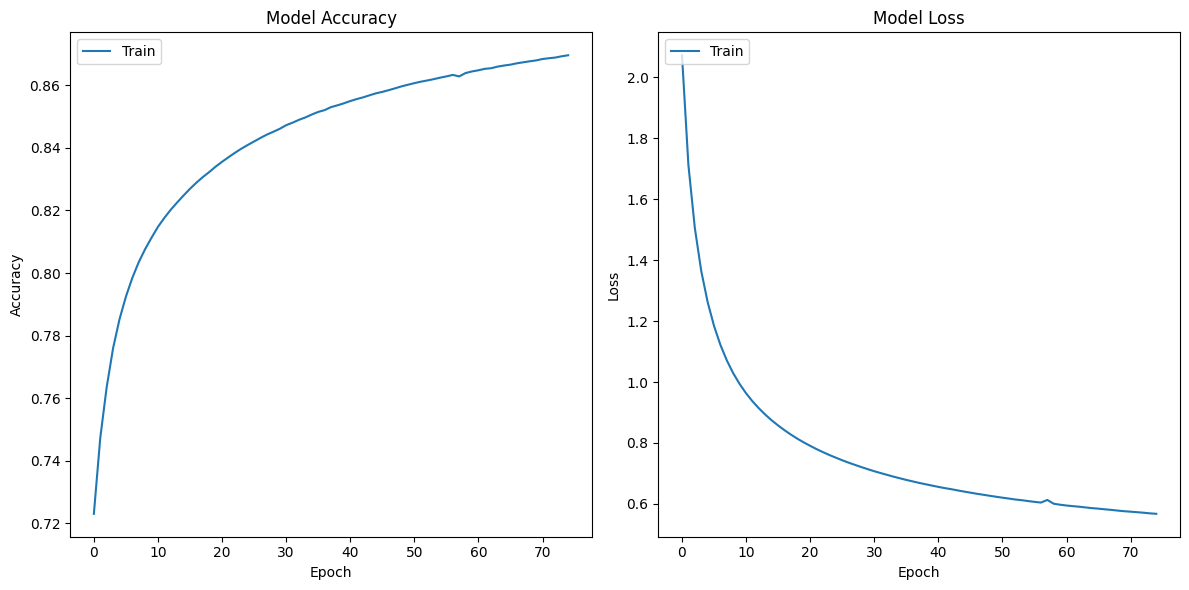

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()


In [ ]:

# Initialize sentiment analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

# Define stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
import os
import sys
import contextlib

@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            yield

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Define global variables
user_model_directory = "user_models/"
preprocessed_corpus_mapping = []
mentioned_fact_indices = []

def preprocess_corpus_once(corpus):
    global preprocessed_corpus_mapping
    lemmatizer = WordNetLemmatizer()
    for keyword, sentences in corpus.items():
        for original_sentence in sentences:
            tokens = word_tokenize(original_sentence.lower())
            lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha() and token not in stop_words]
            preprocessed_sentence = ' '.join(lemmatized_tokens)
            preprocessed_corpus_mapping.append((preprocessed_sentence, original_sentence))

def preprocess_text(text):
    # Tokenize, remove stopwords, and apply lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]
    return ' '.join(tokens)

def load_user_model(user_name):
    try:
        with open(user_model_directory + user_name + '.json', 'r') as file:
            user_model = json.load(file)
    except FileNotFoundError:
        user_model = {"name": user_name, "likes": [], "dislikes": []}
    return user_model

def save_user_model(user_model):
    user_name = user_model["name"]
    directory = user_model_directory
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, user_name + '.json')
    with open(file_path, 'w') as file:
        json.dump(user_model, file, indent=4)

def update_preferences(user_model, preference_type, preference):
    updated = False
    if preference_type == "likes":
        if preference not in user_model["likes"]:
            user_model["likes"].append(preference)
            updated = True
    elif preference_type == "dislikes":
        if preference not in user_model["dislikes"]:
            user_model["dislikes"].append(preference)
            updated = True
    if updated:
        save_user_model(user_model)


def beam_search_predictions(input_seq, encoder_model, decoder_model, tokenizer, max_len=50, beam_width=3):
    # Start with the initial states from the encoder
    states_value = encoder_model.predict(input_seq,verbose = 0)

    # Start sequence initialization
    start_token = [tokenizer.word_index['startseq']]
    start_word = [(start_token, 0.0)]

    while len(start_word[0][0]) < max_len:
        temp = []
        for s in start_word:
            sequence, score = s
            last_word = sequence[-1]
            last_word_arr = np.array([[last_word]])
            output_tokens, h, c = decoder_model.predict([last_word_arr] + states_value)

            # Get top 'beam_width' words
            for i in range(beam_width):
                token = np.argsort(output_tokens[0, -1, :])[-i-1]
                new_score = score + np.log(output_tokens[0, -1, token])
                new_seq = sequence + [token]
                temp.append((new_seq, new_score))

        # Sort the sequences by their scores
        start_word = sorted(temp, key=lambda l: l[1], reverse=True)[:beam_width]
        states_value = [h, c]  # Update states

    best_seq = start_word[0][0]
    final_sentence = [tokenizer.index_word[i] for i in best_seq if i in tokenizer.index_word]
    return ' '.join(final_sentence)

import os
import contextlib

@contextlib.contextmanager
def suppress_stdout_stderr():
    with open(os.devnull, 'w') as fnull:
        with contextlib.redirect_stdout(fnull), contextlib.redirect_stderr(fnull):
            yield

def find_most_relevant_fact(user_query, tokenizer, encoder_model, decoder_model):
    # Preprocess and prepare user query
    user_query_seq = tokenizer.texts_to_sequences([user_query])
    user_query_seq = pad_sequences(user_query_seq, maxlen=max_len, padding='post')

    # Use the context manager to suppress output during beam search predictions
    with suppress_stdout_stderr():
        response = beam_search_predictions(user_query_seq, encoder_model, decoder_model, tokenizer)

    return response.strip('endseq')


def get_fact_response(input_text, user_model):
    fact = find_most_relevant_fact(input_text, tokenizer, encoder_model, decoder_model)
    return f"seq2seq response: {fact}"

import random

def get_greeting():
    greetings = [
        "Hello! Ready to explore the world of Minecraft?",
        "Hi! Got any Minecraft questions? Let's craft some answers!",
        "Welcome! Whether it's crafting, surviving, or building, I'm here to talk all things Minecraft."
    ]
    return random.choice(greetings)



def get_farewell():
    farewells = [
        "That's the end of our Minecraft day! Thanks for chatting, and see you next time!",
        "Time to put the pickaxe down for now. Hope to catch you later for more Minecraft adventures!",
        "And that's the sunset! Looking forward to our next crafting session. Take care!",
        "Nightfall is here! It was great exploring Minecraft with you. Until next time!",
        "The game never really ends, but our chat does for now. Bye, and see you soon!"
    ]
    return random.choice(farewells)


import re

def is_greeting(input_text):
    normalized_text = re.sub(r'[^\w\s]', '', input_text.lower())
    greetings = ["hi", "hello", "hey", "greetings", "good morning", "good afternoon", "good evening", "what's up", "sup", "howdy", "yo"]
    return any(greet in normalized_text.split() for greet in greetings)

def is_farewell(input_text):
    # Normalize the input text to lowercase and strip punctuation
    normalized_text = re.sub(r'[^\w\s]', '', input_text.lower())

    # Extended list of farewells
    farewells = ["bye", "goodbye", "see you", "later", "farewell", "take care", "so long", "till next time"]

    # Check if any farewell is a part of the input text
    return any(farewell in normalized_text.split() for farewell in farewells)

from transformers import pipeline

# Initialize a sentiment-analysis pipeline
sentiment_analyzer = pipeline("sentiment-analysis")

def enhanced_sentiment_analysis(input_text):
    result = sentiment_analyzer(input_text)[0]
    return result['label'].lower()  # Returns 'positive', 'negative', or 'neutral'


def get_positive_response(input_text, user_model):
    positive_responses = [
        "That's wonderful to hear! What do you enjoy most about building in Minecraft?",
        "I'm glad you feel that way! Any favorite creations or adventures you'd like to share?",
        "Positivity is great! Got any cool projects or discoveries to discuss?",
        "That’s really great to hear! What inspired you to start playing Minecraft?",
        "Awesome! Hearing about your Minecraft adventures is always exciting. What's your next big project?",
        "That’s fantastic! How long have you been crafting in your Minecraft world?",
        "Excellent! Know any friends who also love exploring Minecraft as much as you do?",
        "Superb! Do you often get this excited about new updates or mods?",
        "That's exciting! Can you share more about what aspects of Minecraft captivate you the most?",
        "Love the energy! What new skills or challenges are you looking to tackle in Minecraft next?"
    ]
    return random.choice(positive_responses)



def get_negative_response(input_text, user_model):
    # Minecraft-themed negative response options
    negative_responses = [
        "I'm sorry to hear that. Maybe a different building style or biome would suit you better?",
        "Everyone has their Minecraft preferences. What do you enjoy crafting or exploring the most?",
        "It's okay not to like every aspect of Minecraft. Have you had any positive experiences with mods or community servers?",
        "That's unfortunate. Would you like to explore other areas like Redstone mechanics or new world seeds?",
        "I understand that might be frustrating. Do you have a favorite type of adventure or challenge in Minecraft?",
        "Sorry to hear you're not enjoying that aspect. Maybe I can suggest some fun Minecraft challenges or projects?",
        "It’s important to find what you love in Minecraft. Are there specific resources or tools you're looking for help with?",
        "Minecraft isn't for everyone in every way. What parts of the game do you feel most passionate about?",
        "I appreciate your honesty. Is there a way I can help make your Minecraft experience more enjoyable?",
        "That's valuable feedback, thank you. Would you like to discuss other features like survival tips or crafting recipes?"
    ]
    return random.choice(negative_responses)



def is_question(input_text):
    if "what do you like" in input_text:
        return False

    tokens = nltk.word_tokenize(input_text.lower())
    tagged_tokens = nltk.pos_tag(tokens)

    # Checking for question words
    question_words = ["what", "how", "why", "when", "where", "who"]
    if tagged_tokens[0][0] in question_words or "?" in input_text:
        return True

    return False

def get_question_response(input_text, user_model):
    # Dynamic handling for questions related to Minecraft
    if "minecraft" in input_text:
        return "Minecraft is a sandbox game where you can build, mine, battle mobs, and explore endless worlds. What specific aspect are you curious about?"
    elif "crafting" in input_text:
        return "Crafting is a fundamental part of Minecraft. You can create everything from simple tools to complex mechanisms. What would you like to craft?"
    elif "survival" in input_text:
        return "Survival mode is all about managing resources, maintaining health, and building a safe shelter. Need tips on surviving your first night?"
    else:
        return "I'm here to help with your Minecraft adventures! Not sure about that one, but ask me anything else about the game."


import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

def is_preference_query(input_text):
    tokens = word_tokenize(input_text.lower())
    tagged_tokens = pos_tag(tokens)
    preference_keywords = ["like", "dislike", "likes", "dislikes", "love", "hate", "prefer", "admire", "detest"]
    has_preference_keywords = any(word in preference_keywords for word, tag in tagged_tokens)
    has_query_words = any(word in ["what", "know", "think", "how"] for word, tag in tagged_tokens)
    return has_preference_keywords and has_query_words

def list_preferences(user_model, preference_type):
    if preference_type == "likes" and user_model["likes"]:
        return f"I know you like {', '.join(user_model['likes'])}."
    elif preference_type == "dislikes" and user_model["dislikes"]:
        return f"I know you dislike {', '.join(user_model['dislikes'])}."
    return f"I don't have any recorded {preference_type} for you."

def pattern_recognition_and_response(input_text, user_model):
    if ("tell me about minecraft" in input_text or
        "what is minecraft" in input_text or
        "what is crafting" in input_text or
        "what is survival" in input_text):
        return get_question_response(input_text, user_model)

    # Define preference patterns
    preference_patterns = {
        "like": "likes",
        "dislike": "dislikes",
        "love": "likes",  # Mapped to likes
        "hate": "dislikes",  # Mapped to dislikes
        "prefer": "likes",
        "admire": "likes",
        "detest": "dislikes"
    }

    # Combine the patterns into a regex pattern
    preference_regex = r"\b(" + "|".join(preference_patterns.keys()) + r")\b (.+)"
    preference_match = re.search(preference_regex, input_text, re.IGNORECASE)

    if preference_match:
        preference_verb = preference_match.group(1).lower()  # The matched preference verb
        preference_content = preference_match.group(2)  # The content after the preference verb
        preference_type = preference_patterns[preference_verb]
        update_preferences(user_model, preference_type, preference_content)
        response = f"I've noted that you {preference_verb} {preference_content}."
        if preference_type == "likes":
          response = get_positive_response(input_text, user_model)
          return response + " What else do you enjoy?"
        else:
          response = get_negative_response(input_text, user_model)
          return response + " What do you like, then?"
    if "what do you like" in input_text:
        return f"I like {random.choice(chatbot_likes)}. What about you?"

    if is_question(input_text):
        fact_response = get_fact_response(input_text, user_model)
        return fact_response

    if is_preference_query(input_text):
        # Respond with known likes or dislikes
        likes_response = list_preferences(user_model, "likes")
        dislikes_response = list_preferences(user_model, "dislikes")
        return f"{likes_response} {dislikes_response}"

    if "?" in input_text:
        return get_question_response(input_text, user_model)
    if "fact" in input_text:
        return get_fact_response(input_text, user_model)

    sentiment = enhanced_sentiment_analysis(input_text)
    if sentiment == "positive":
        return get_positive_response(input_text, user_model)
    elif sentiment == "negative":
        return get_negative_response(input_text, user_model)

    if not user_model["likes"] and not user_model["dislikes"]:
        hobby_questions = [
            "What are some of your favorite things to do in Minecraft? Do you prefer building, exploring, or crafting?",
            "I'd love to hear more about your Minecraft adventures. Any favorite builds or projects you're working on?",
            "Tell me about your interests in Minecraft. What aspects of the game do you find most enjoyable?"
        ]
        return random.choice(hobby_questions)

    return "Can you tell me more? I'm here to chat about anything, especially Minecraft."


def update_preferences(user_model, preference_type, preference):
    if preference_type == "likes":
        if preference not in user_model["likes"]:
            user_model["likes"].append(preference)
    elif preference_type == "dislikes":
        if preference not in user_model["dislikes"]:
            user_model["dislikes"].append(preference)

def enhanced_chat():
    #preprocess_corpus_once(modified_corpus)
    print("Welcome to the MineCraft QA Chatbot!")
    user_name = input("Who are you? ").strip()
    user_model = load_user_model(user_name)

    print(f"{get_greeting()} Welcome to your Minecraft guide! What would you like to explore or build today?")
    print("NOTE: to get a seq2seq response, you must end your query with a question mark")

    while True:
        user_input = input("> ").lower()
        if is_farewell(user_input):
            print(get_farewell())
            break
        response = pattern_recognition_and_response(user_input, user_model)
        print(response)

    save_user_model(user_model)


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-unc

In [ ]:
if __name__ == "__main__":
    enhanced_chat()


Welcome to the MineCraft QA Chatbot!
Who are you? Arvind
Hi! Got any Minecraft questions? Let's craft some answers! Welcome to your Minecraft guide! What would you like to explore or build today?
NOTE: to get a seq2seq response, you must end your query with a question mark
> What is minecraft
Minecraft is a sandbox game where you can build, mine, battle mobs, and explore endless worlds. What specific aspect are you curious about?
> What do you like
I like sharing facts about minecraft. What about you?
> I love the cats in minecraft
Excellent! Know any friends who also love exploring Minecraft as much as you do? What else do you enjoy?
> I also like all the tree designs in minecraft too!
Superb! Do you often get this excited about new updates or mods? What else do you enjoy?
> I do hate the creepers in minecraft though. They kill me everytime
I appreciate your honesty. Is there a way I can help make your Minecraft experience more enjoyable? What do you like, then?
>  What is the first s